# 人工智能安全作业1
任务：使用cifar10数据集进行图像分类任务  
具体内容：使用Python语言，用jupyter notebook作为编辑器，使用PyTorch框架建立模型，通过torchvision.datasets包加载数据集，最后在测试集上得到了超过随机模型（10%）的准确率结果

In [26]:
#导包
import math

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [3]:
#导入数据
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,  download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


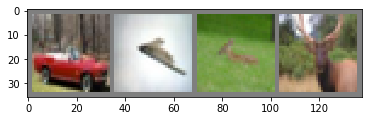

  car           plane            deer            deer


In [9]:
#展示一组示例数据

#可视化函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#随机获取一组训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

#展示图片
imshow(torchvision.utils.make_grid(images))
#打印标签
print('           '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [31]:
#建立模型
class Net(nn.Module):
    def __init__(self,input_channel=3,h=32,w=32,hidden_channel=[6,16],conv_kernel_size=5,pool_kernel_size=2,pool_stride=2,
                hidden_dim=[120,84],output_dim=10):
        """hidden_channel和hidden_dim接受int和list两种格式，其他参数只接受如示例格式"""
        super().__init__()
        if isinstance(hidden_channel,int):
            hidden_channel=[hidden_channel,hidden_channel]
        if isinstance(hidden_dim,int):
            hidden_dim=[hidden_dim,hidden_dim]
        self.conv1 = nn.Conv2d(input_channel,hidden_channel[0],conv_kernel_size)
        h2=math.floor(h-conv_kernel_size+1)
        #print(h2)
        w2=math.floor(w-conv_kernel_size+1)
        #print(w2)
        self.pool = nn.MaxPool2d(pool_kernel_size,pool_stride)
        h3=math.floor((h2-pool_kernel_size)/pool_stride+1)
        #print(h3)
        w3=math.floor((w2-pool_kernel_size)/pool_stride+1)
        #print(w3)
        self.conv2 = nn.Conv2d(hidden_channel[0],hidden_channel[1],conv_kernel_size)
        h4=math.floor(h3-conv_kernel_size+1)
        #print(h4)
        w4=math.floor(w3-conv_kernel_size+1)
        #print(w4)
        h5=math.floor((h4-pool_kernel_size)/pool_stride+1)
        #print(h5)
        w5=math.floor((w4-pool_kernel_size)/pool_stride+1)
        #print(w5)
        self.fc1_input_dim=hidden_channel[1]*h5*w5
        self.fc1 = nn.Linear(self.fc1_input_dim,hidden_dim[0])
        self.fc2 = nn.Linear(hidden_dim[0],hidden_dim[1])
        self.fc3 = nn.Linear(hidden_dim[1],output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,self.fc1_input_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

上一NN的单张图数据特征尺寸在网络层之间的变化是：
$input\_channel*h*w\xrightarrow{(conv1)}hidden\_channels[0]*floor(h-conv\_kernel\_size+1)（h2）*floor(w-conv\_kernel\_size+1)（w2）\xrightarrow{(pool)}hidden\_channels[0]*floor(\frac{h2-pool\_kernel\_size}{pool\_stride}+1)（h3）*floor(\frac{w2-pool\_kernel\_size}{pool\_stride}+1)（w3）\xrightarrow{(conv2)}hidden\_channels[1]*floor(h3-conv\_kernel\_size+1)（h4）*floor(w3-conv\_kernel\_size+1)（w4）\xrightarrow{(pool)}hidden\_channels[1]*floor(\frac{h4-pool\_kernel\_size}{pool\_stride}+1)（h5）*floor(\frac{w4-pool\_kernel\_size}{pool\_stride}+1)（w5）$  
默认情况就是：  
$3*32*32\xrightarrow{(conv1)}6*28*28\xrightarrow{(pool)}6*14*14\xrightarrow{(conv2)}16*10*10\xrightarrow{(pool)}16*5*5\xrightarrow{(fc1)}120\xrightarrow{(fc2)}84\xrightarrow{(fc3)}10$

In [12]:
!nvidia-smi

Sun Oct 17 16:24:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.30       Driver Version: 462.30       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX350      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8    N/A /  N/A |     68MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
#设置超参
device=('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate=0.001
momentum=0.9
epoch=2
net_hyperparameter={'hidden_channel':[6,8],'conv_kernel_size':5,'pool_kernel_size':2,'pool_stride':2,'hidden_dim':64}


#建立pipeline
net = Net(**net_hyperparameter)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for e in range(epoch):
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print('第'+str(e+1)+'个epoch上的总损失函数为：'+str(total_loss))
print('Finished Training')

第1个epoch上的总损失函数为：22216.302551686764
第2个epoch上的总损失函数为：17673.934921719134
Finished Training


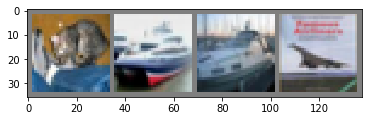

GroundTruth:   cat  ship  ship plane


In [45]:
#输出模型预测结果的示例
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [46]:
#打印模型在测试集上的准确率
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('模型在'+str(total)+'张测试集图片上的准确率为：%d%%' % (100 * correct / total))

模型在10000张测试集图片上的准确率为：49%


In [47]:
#打印模型在每一类标签上的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('%5s 标签上的准确率为： %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

plane 标签上的准确率为： 52 %
  car 标签上的准确率为： 76 %
 bird 标签上的准确率为： 47 %
  cat 标签上的准确率为： 37 %
 deer 标签上的准确率为： 25 %
  dog 标签上的准确率为： 23 %
 frog 标签上的准确率为： 78 %
horse 标签上的准确率为： 48 %
 ship 标签上的准确率为： 41 %
truck 标签上的准确率为： 66 %
